In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import shutil
import argparse
from typing import List, Union
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
import logging

import torch
from torch import Tensor, nn
from torch.types import Device, _size
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from configs.config import configs

from models.pe import PositionalEncoding
from models.resnet1D import *
from models.transformer_encoder import transformer_classifier

2024-10-17 11:11:24.439642: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 11:11:24.460404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 11:11:24.741212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Init logging
import logging

logger = logging.getLogger(__name__)  # Use the current module's name
logging.basicConfig(level=logging.INFO)
# logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# handler.setFormatter(formatter)
logger.addHandler(handler)
acc_example = 0.95  # Replace with your actual accuracy calculation
logger.info(f"Current accuracy: %{acc_example}")  # Log as info
# logger.debug("Current accuracy: %.2f", accuracy)  # Log as info

Current accuracy: %0.95
INFO:__main__:Current accuracy: %0.95


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("config_file", metavar="FILE", help="config file")
# parser.add_argument('--run-dir', metavar='DIR', help='run directory')
# parser.add_argument('--pdb', action='store_true', help='pdb')
args = parser.parse_args(args=['configs/abnormal_12000.yml'])
# args, opts = parser.parse_known_args()
# f = 'configs/eeg_pt.yml'
with open(args.config_file, 'r') as file:
    Configs = yaml.safe_load(file)

In [4]:
class model(nn.Module):
    def __init__(self, input_size: int, n_channels: int, model_hyp: dict, classes: int):
        super(model, self).__init__()
        self.ae = resnet18(n_channels=n_channels, groups=n_channels, num_classes=classes, d_model=model_hyp['d_model'])
#         self.transformer_encoder = transformer_classifier(input_size, n_channels, model_hyp, classes)
        self.mlp = nn.Sequential(
                    nn.Linear(n_channels*model_hyp['d_model'], n_channels*model_hyp['d_model']//8),
                    nn.ReLU(),
                    nn.Linear(n_channels*model_hyp['d_model']//8, n_channels*model_hyp['d_model']//32),
                    nn.ReLU(),
                    nn.Linear(n_channels*model_hyp['d_model']//32, classes),
                )
        
        self.reset_parameters()
        
    def reset_parameters(self):
        r"""Initiate parameters in the model."""
        
        for p in self.parameters():
            if p.dim() > 1:
#                 logger.debug(p.shape)
                nn.init.xavier_uniform_(p)
                    
        for m in self.modules():
#             print(m)
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        print('Complete initiate parameters')

    def forward(self, x):
#         z = self.pe(x)
        z = x.transpose(-1,-2)
        z = self.ae(z)
        z = torch.flatten(z, 1)
        y = self.mlp(z)
#         z = self.transformer_encoder(z)
        return y

In [5]:
# Transform signal
def transform(data:Tensor, mean:Tensor, std:Tensor):
    normalized_data = (data - mean) / std
    return normalized_data

# ### Dataset

class customDataset(Dataset):
    def __init__(self, data_dir:str, label_dir:str, label_dict:dict, mean: list, std: list, transform=None):
#         self.annotations = pd.read_csv(label_dir)
        self.data_dir = data_dir   # './data/origin_csv/train'
        self.label_dir = label_dir
        self.transform = transform
        self.files = os.listdir(self.data_dir)
        self.annotations = pd.read_csv(self.label_dir)
        self.label_dict = label_dict
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        data_path = os.path.join(self.data_dir, self.files[index])
        data = pd.read_csv(data_path)
        data = torch.tensor(data.values, dtype=torch.float32)
        file_name = self.files[index]
        
        label = torch.tensor(int(self.label_dict[self.annotations.iloc[index,1]]))
        
        if self.transform:
            data = self.transform(data, self.mean, self.std)
            
        return (data, label, file_name)

In [6]:
train_data_dir = Configs['dataset']['train_data_dir']
train_label_dir = Configs['dataset']['train_label_dir']

val_data_dir = Configs['dataset']['val_data_dir']
val_label_dir = Configs['dataset']['val_label_dir']

label_dict = Configs['dataset']['classes']

mean =  Configs['dataset']['mean']
std =  Configs['dataset']['std']

train_dataset = customDataset(data_dir=train_data_dir,
                              label_dir=train_label_dir,
                              label_dict=label_dict,
                              mean=mean,
                              std=std,
                             transform=transform)
val_dataset = customDataset(data_dir=val_data_dir,
                            label_dir=val_label_dir,
                            label_dict=label_dict,
                            mean=mean,
                            std=std,
                           transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=1,
                              shuffle=Configs['dataset']['shuffle'], 
                          num_workers=Configs['dataset']['num_workers'], pin_memory=True)

eval_loader = DataLoader(dataset=val_dataset, num_workers=Configs['dataset']['num_workers'], 
                         shuffle=Configs['dataset']['shuffle'], pin_memory=True)

# classifier = model(input_size=Configs['input_size'],
#                                     n_channels = Configs['n_channels'],
#                                     model_hyp=Configs['model'],
#                                     classes=len(Configs['dataset']['classes'])).to('cuda')

# input_layer = nn.Sequential(
# #         nn.Embedding(num_embeddings=10000, embedding_dim=512),
# #         PositionalEncoding(d_model=512, dropout=0.1, max_len=5000)
#     PositionalEncoding(d_model=Configs['n_channels'], max_len=Configs['input_size'])
# ).to('cuda')

classifier = model(input_size=Configs['input_size'],
                                        n_channels = Configs['n_channels'],
                                        model_hyp=Configs['model'],
                                        classes=len(Configs['dataset']['classes'])).to('cuda')
optimizer = torch.optim.Adam(classifier.parameters(),betas=(0.9,0.999),lr=Configs['optimizer']['init_lr'])
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter(Configs['tensorboard']['runs_dir']+'train_board')    # Initialize tensorflow

Complete initiate parameters


/home/yossi/.local/lib/python3.8/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
state_dict = torch.load(Configs['checkpoint']['checkpoint_dir']+'2410162241_resnet18_params_best.pth')
classifier.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
classifier.

model(
  (ae): ResNet(
    (conv1): Conv1d(19, 152, kernel_size=(7,), stride=(2,), padding=(3,), groups=19, bias=False)
    (ln1): LayerNorm((6000,), eps=1e-05, elementwise_affine=True)
    (relu): ReLU(inplace=True)
    (avgpool_1): AvgPool1d(kernel_size=(3,), stride=(2,), padding=(1,))
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(152, 152, kernel_size=(3,), stride=(1,), padding=(1,), groups=19, bias=False)
        (ln1): LayerNorm((3000,), eps=1e-05, elementwise_affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(152, 152, kernel_size=(3,), stride=(1,), padding=(1,), groups=19, bias=False)
        (ln2): LayerNorm((3000,), eps=1e-05, elementwise_affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv1d(152, 152, kernel_size=(3,), stride=(1,), padding=(1,), groups=19, bias=False)
        (ln1): LayerNorm((3000,), eps=1e-05, elementwise_affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(152, 152, kernel_size

In [9]:
iter_train = iter(train_loader)
iter_eval = iter(eval_loader)

### Forward hoop define

In [10]:
# Define a folder to save feature maps
output_folder = 'feature_maps'
os.makedirs(output_folder, exist_ok=True)

# Hook function to save feature maps
# feature_maps = []

def train_hook_fn(module, input, output):
    train_feature_maps.append(output)

def eval_hook_fn(module, input, output):
    eval_feature_maps.append(output)

# Function to save feature maps as images
def save_feature_maps_as_images(feature_maps, epoch, output_folder):
    for idx, fmap in enumerate(feature_maps):
        fmap = fmap.detach().cpu().numpy()  # Convert to numpy array
        num_channels = fmap.shape[1]
        for channel in range(num_channels):
            plt.imshow(fmap[0, channel], cmap='viridis')  # Display one feature map channel
            plt.colorbar()
            plt.title(f'Epoch {epoch}, Feature Map {idx + 1}, Channel {channel + 1}')
            plt.savefig(os.path.join(output_folder, f'epoch_{epoch}_feature_map_{idx+1}_channel_{channel+1}.png'))
            plt.close()

In [11]:
train_data, train_target, train_file = next(iter_train)
train_data, train_target = train_data.to('cuda'), train_target.to('cuda')

eval_data, eval_target, eval_file = next(iter_eval)
eval_data, eval_target = eval_data.to('cuda'), eval_target.to('cuda')

In [12]:
# Run model and save feature map as images.
# Training loop with feature map extraction every 5 epochs
train_feature_maps = []  # Reset feature maps for the new epoch
eval_feature_maps = []  # Reset feature maps for the new epoch

# Simulate input EEG signal (batch_size=1, channels=1, height=64, width=64)
# input_signal = torch.randn(1, 1, 64, 64)

# Register the hooks for the desired layers
hook0 = classifier.ae.ln1.register_forward_hook(train_hook_fn)
hook1 = classifier.ae.relu.register_forward_hook(train_hook_fn)
hook2 = classifier.ae.avgpool_1.register_forward_hook(train_hook_fn)
hook3 = classifier.ae.layer1.register_forward_hook(train_hook_fn)
hook4 = classifier.ae.layer2.register_forward_hook(train_hook_fn)
hook5 = classifier.ae.layer3.register_forward_hook(train_hook_fn)
hook6 = classifier.ae.layer4.register_forward_hook(train_hook_fn)
hook7 = classifier.mlp[1].register_forward_hook(train_hook_fn)  # mlp_linear1+relu
hook8 = classifier.mlp[3].register_forward_hook(train_hook_fn)  # mlp_linear2+relu
hook9 = classifier.mlp[4].register_forward_hook(train_hook_fn)  # mlp_linear3
hook10 = classifier.mlp.register_forward_hook(train_hook_fn)  # feature map of mlp

train_output = classifier(train_data)
train_loss = criterion(train_output, train_target)
train_probabilities = torch.softmax(train_output, dim=1)  # Apply softmax to get probabilities
_, train_predicted = torch.max(train_probabilities, 1)  # Get the predicted class

# Remove hooks after use to avoid unnecessary overhead
hook0.remove()
hook1.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()
hook7.remove()
hook8.remove()
hook9.remove()
hook10.remove()


# Simulate input EEG signal (batch_size=1, channels=1, height=64, width=64)
# input_signal = torch.randn(1, 1, 64, 64)

# Register the hooks for the desired layers
hook0 = classifier.ae.ln1.register_forward_hook(eval_hook_fn)
hook1 = classifier.ae.relu.register_forward_hook(eval_hook_fn)
hook2 = classifier.ae.avgpool_1.register_forward_hook(eval_hook_fn)
hook3 = classifier.ae.layer1.register_forward_hook(eval_hook_fn)
hook4 = classifier.ae.layer2.register_forward_hook(eval_hook_fn)
hook5 = classifier.ae.layer3.register_forward_hook(eval_hook_fn)
hook6 = classifier.ae.layer4.register_forward_hook(eval_hook_fn)
hook7 = classifier.mlp[1].register_forward_hook(eval_hook_fn)  # mlp_linear1+relu
hook8 = classifier.mlp[3].register_forward_hook(eval_hook_fn)  # mlp_linear2+relu
hook9 = classifier.mlp[4].register_forward_hook(eval_hook_fn)  # mlp_linear3
hook10 = classifier.mlp.register_forward_hook(eval_hook_fn)  # feature map of mlp

eval_output = classifier(eval_data)
eval_loss = criterion(eval_output, eval_target)
# eval_loss += loss.item()
#  outputs = model(data)  # Forward pass to get logits
eval_probabilities = torch.softmax(eval_output, dim=1)  # Apply softmax to get probabilities
_, eval_predicted = torch.max(eval_probabilities, 1)  # Get the predicted class

# Remove hooks after use to avoid unnecessary overhead
hook0.remove()
hook1.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()
hook7.remove()
hook8.remove()
hook9.remove()
hook10.remove()
# hook1 = classifier.ae.layer4[1].conv2.register_forward_hook(hook_fn)
# hook100 = classifier.ae.avgpool_2.register_forward_hook(hook_fn)

# hook2 = classifier.ae.avgpool_1.register_forward_hook(hook_fn)

# Forward pass
# input_signal = input_layer(eval_data)
  # Simulating target class
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()




    

/home/yossi/anaconda3/envs/python38/lib/python3.8/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608851799/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


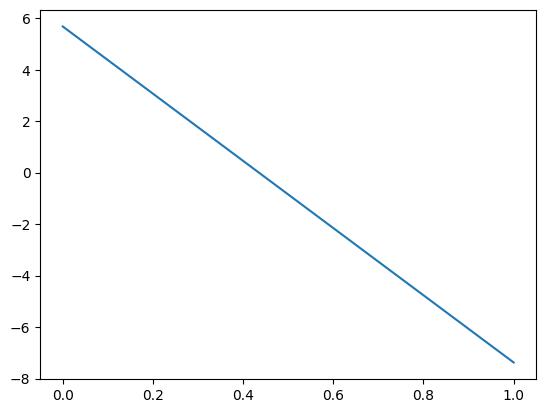

In [17]:
import matplotlib.pyplot as plt
feature_map = eval_feature_maps[9].detach().cpu().numpy()
plt.plot(feature_map[0])  # Display one feature map channel
# plt.colorbar()
# plt.title(f'Epoch {epoch}, Feature Map {idx + 1}, Channel {channel + 1}')
# plt.title(f'Feature Map {idx + 1}')
# plt.savefig(os.path.join('eval_ae_avgpool_2.png'))
plt.savefig(os.path.join('train_mlp.png'))
# plt.close()

In [18]:
feature_map

array([[ 5.6797266, -7.3760576]], dtype=float32)